In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
img_rows = 120
img_cols = 120
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2DTranspose
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from PIL import Image
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
import csv

In [0]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 60, 60, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 31, 31, 64)       

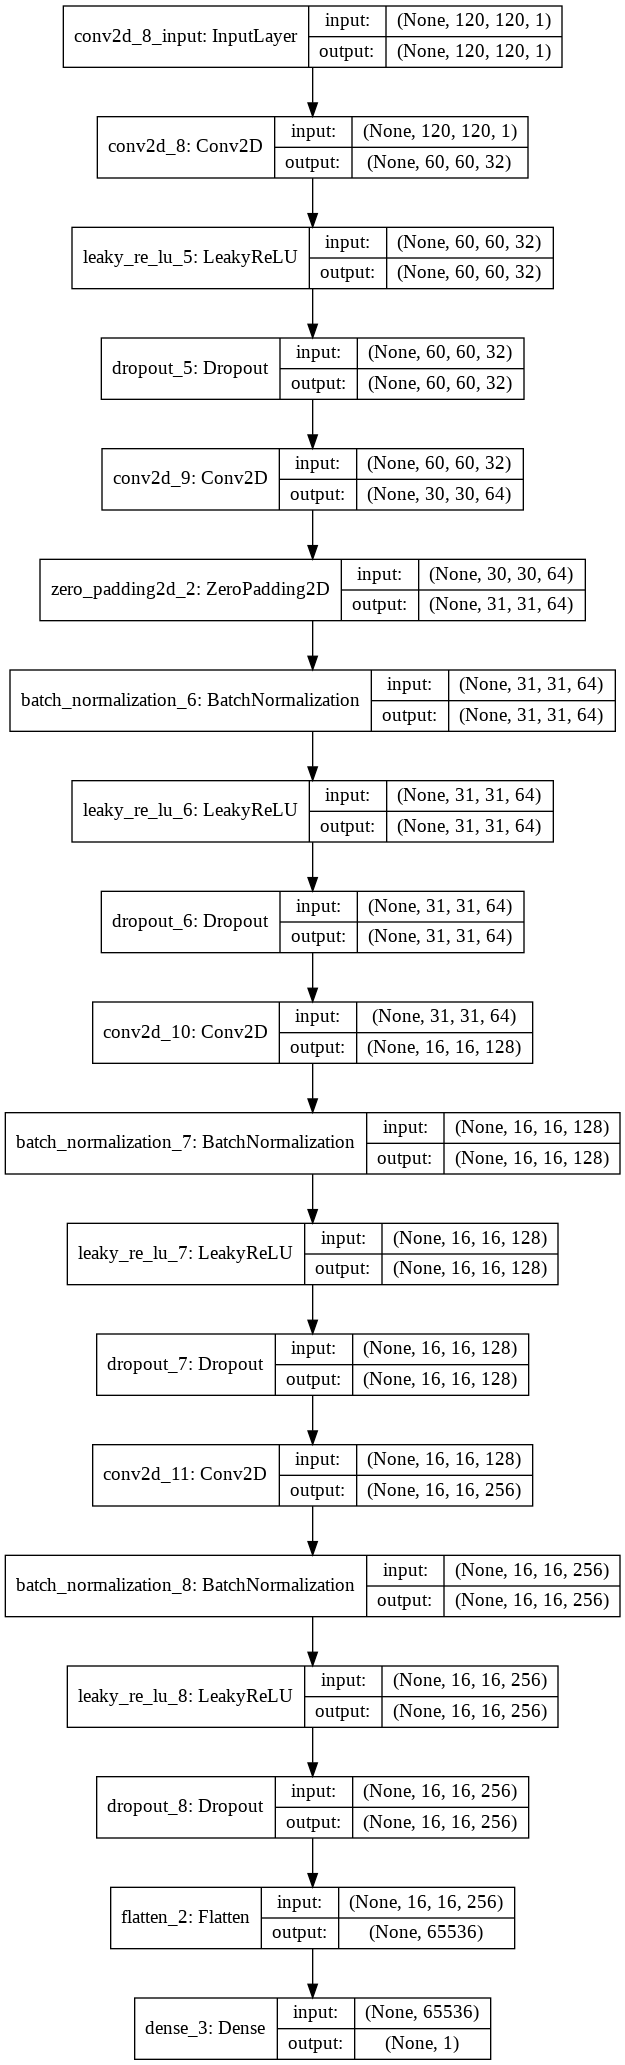

In [0]:
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def build_generator():
    model = Sequential()
    model.add(Dense(512 * 30 * 30, activation="relu", input_dim=latent_dim))
    model.add(Reshape((30,30, 512)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 460800)            46540800  
_________________________________________________________________
reshape_2 (Reshape)          (None, 30, 30, 512)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 60, 60, 512)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 128)       589952    
_________________________________________________________________
batch_normalization_9 (Batch (None, 60, 60, 128)       512       
_________________________________________________________________
activation_4 (Activation)    (None, 60, 60, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 120, 120, 128)    

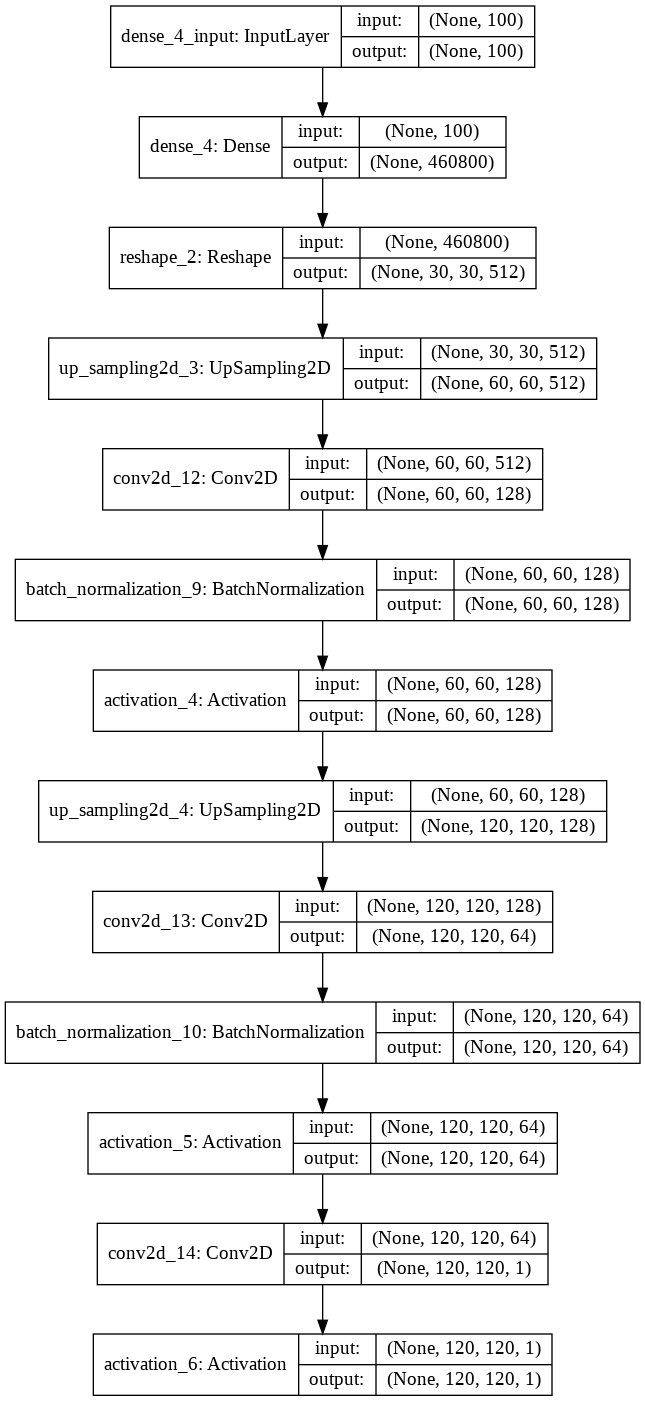

In [0]:
generator = build_generator()
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 120, 120, 1)       47205889  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 455169    
Total params: 47,661,058
Trainable params: 47,205,505
Non-trainable params: 455,553
_________________________________________________________________


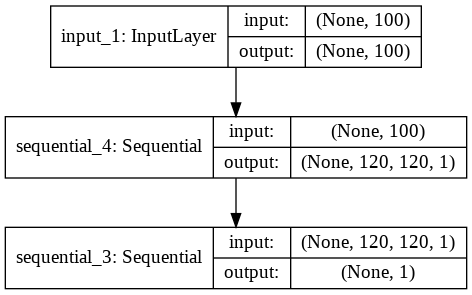

In [0]:
discriminator.trainable = False
input_layer = Input(shape=(100,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)
gan = Model(input_layer,disc_out)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()
plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def train(epochs, batch_size, save_interval):
    #make directory
    os.makedirs('images', exist_ok=True)

    #read our csv file from drive
    read=pd.read_csv("/content/drive/My Drive/internship_GAN/3g.csv")
    read1 = read.iloc[:,:].values
    X_train=np.array
    X_train= read1.reshape(718,120,120)

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial gives label 1 to valid images and 0 to fake 
    real_tag = np.ones((batch_size, 1))
    fake_tag = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, real_tag)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake_tag)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = gan.train_on_batch(noise,real_tag)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d D_loss: %f, acc.: %.2f%% and G_loss: %f" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)

In [0]:
def save_imgs(epoch):
    #r, c = 5, 5
    noise = np.random.normal(0, 1, (1000, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    '''
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/characters_%d.png" % epoch)
    plt.close()
'''
    if epoch == 9900:
      arraytocsv(gen_imgs)

**Generated array to CSV**

In [0]:
def arraytocsv(gen_imgs):
  x=np.array
  x=gen_imgs
  x=np.squeeze(x, axis=(3,))
  new = np.reshape(x, (1000,14400))
  np.savetxt('g3.csv', new, delimiter=',')

In [0]:
train(epochs=10000, batch_size=4, save_interval=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 D_loss: 1.095769, acc.: 25.00% and G_loss: 0.944833


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 D_loss: 0.826031, acc.: 50.00% and G_loss: 1.633199
200 D_loss: 0.651742, acc.: 87.50% and G_loss: 2.420278
300 D_loss: 2.683992, acc.: 12.50% and G_loss: 1.068199
400 D_loss: 0.150825, acc.: 100.00% and G_loss: 2.021513
500 D_loss: 1.642398, acc.: 12.50% and G_loss: 3.486323
600 D_loss: 0.352615, acc.: 87.50% and G_loss: 0.849096
700 D_loss: 1.043838, acc.: 50.00% and G_loss: 2.600095
800 D_loss: 0.883620, acc.: 62.50% and G_loss: 2.793983
900 D_loss: 0.980469, acc.: 62.50% and G_loss: 2.097386
1000 D_loss: 0.609650, acc.: 62.50% and G_loss: 2.408013
1100 D_loss: 0.807545, acc.: 62.50% and G_loss: 1.852128
1200 D_loss: 0.307912, acc.: 75.00% and G_loss: 1.537818
1300 D_loss: 0.687213, acc.: 50.00% and G_loss: 1.904609
1400 D_loss: 0.755260, acc.: 75.00% and G_loss: 2.673494
1500 D_loss: 0.159195, acc.: 100.00% and G_loss: 2.604260
1600 D_loss: 1.091328, acc.: 37.50% and G_loss: 1.313294
1700 D_loss: 0.536450, acc.: 75.00% and G_loss: 1.808237
1800 D_loss: 0.888482, acc.: 62.50% an

**Read the generated file and plot it**

In [0]:
gene=pd.read_csv("g3.csv").values
x_train=np.array
x_train = gene.reshape(999,120,120)

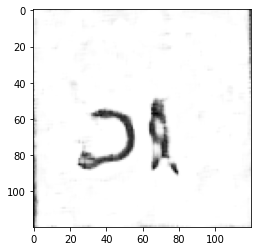

In [0]:
plt.imshow(x_train[800],cmap='gray')
plt.show()

# Recognition using Generated Image

In [4]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pandas as pd
import numpy as np

batch_size = 4
num_classes = 4
epochs = 10

# input image dimensions
img_rows, img_cols = 120,120

read=pd.read_csv("/content/drive/My Drive/internship_GAN/generated/train_kkhggh.csv").values
arr=np.array
arr = read.reshape(3199,120,120,1)
x_train=arr
readt=pd.read_csv("/content/drive/My Drive/internship_GAN/generated/test_kkhggh.csv").values
arrt=np.array
arrt = readt.reshape(799,120,120,1)
x_test=arrt
y_train=pd.read_csv("/content/drive/My Drive/internship_GAN/generated/train_label_kkhggh.csv").values
y_test=pd.read_csv("/content/drive/My Drive/internship_GAN/generated/test_label_kkhggh.csv").values


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
'''
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
'''
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (3199, 120, 120, 1)
3199 train samples
799 test samples
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 3199 samples, validate on 799 samples
Epoch 1/10
3199/3199 [==============================] - 23s 7ms/step - loss: 0.5318 - accuracy: 0.8021 - val_loss: 0.1181 - val_accuracy: 0.9625
Epoch 2/10
3199/3199 [==============================] - 17s 5ms/step - loss: 0.1231 - accuracy: 0.9606 - val_loss: 0.0859 - val_accuracy: 0.9687
Epoch 3/10
3199/3199 [==============================] - 16s 5ms/step - loss: 0.0939 - accuracy: 0.9716 - val_loss: 0.0588 - val_accuracy: 0.9825
Epoch 4/10
3199/3199 [==============================] - 17s 5ms/step - loss: 0.0617 - accuracy: 0.9800 - val_loss: 0.0536 - val_accuracy: 0.9825
Epoch 5/10
3199/3199 [==============================] - 16s 5ms/step - loss: 0.0363 - accuracy: 0.9884 - val_loss: 0.0551 - val_accuracy: 0.9825
Epoch 6/10
3199/3199 [==============================] - 16s 5ms/step - los

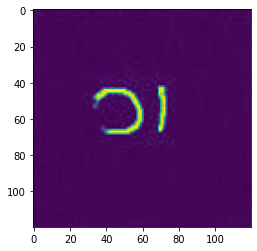

<class 'numpy.ndarray'>
(120, 120)


In [9]:
from numpy import asarray
import cv2
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

im = Image.open('14.png').convert('L')

im_invert = ImageOps.invert(im)

size = (120,120)
new_image = im_invert.resize(size)

plt.imshow(new_image)
plt.show()
data=np.array
data = asarray(new_image)
print(type(data))
print(data.shape)
data = data.astype('float32')
data /= 255

[[5.2442530e-04 9.7696550e-08 9.9947542e-01 1.5877433e-07]]
[[0. 0. 1. 0.]]


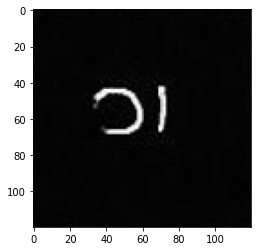

2


In [10]:
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
example = data
prediction = model.predict(example.reshape(1,120,120, 1))
print (prediction)
hard_maxed_prediction = np.zeros(prediction.shape)
hard_maxed_prediction[0][np.argmax(prediction)] = 1
print (hard_maxed_prediction)

plt.imshow(example.reshape(120,120), cmap="gray")
plt.show()
print(np.argmax(prediction))